# Classification and Regression Trees
by Elliot Cohen, Ph.D.  

**Requirements**: Python 3.6 with the following packages: `pandas`, `numpy`, `scikit-learn`, `pydotplus`, `IPython`  
You can install packages in a Jupyter Notebook as follows:
```!pip install <package>```

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score # classification only
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble

from IPython.display import Image
import pydotplus

## Example 1: Classification Trees

In [2]:
# import data
header_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/field_names.txt'
data_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/breast-cancer.csv'

header_list = pd.read_csv(header_url, header=None, squeeze=True).tolist();
data = pd.read_csv(data_url, header=None, names=header_list, index_col='ID')

In [3]:
# divide data into predictors (X) and predictand (y), and subdivide into test/train sets.
Y = data['diagnosis'].replace({'M': True, 'B': False}) # convert to binary outcome
X = data.iloc[:, data.columns != 'diagnosis']

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.4)

In [4]:
# fit a classifier
clf = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

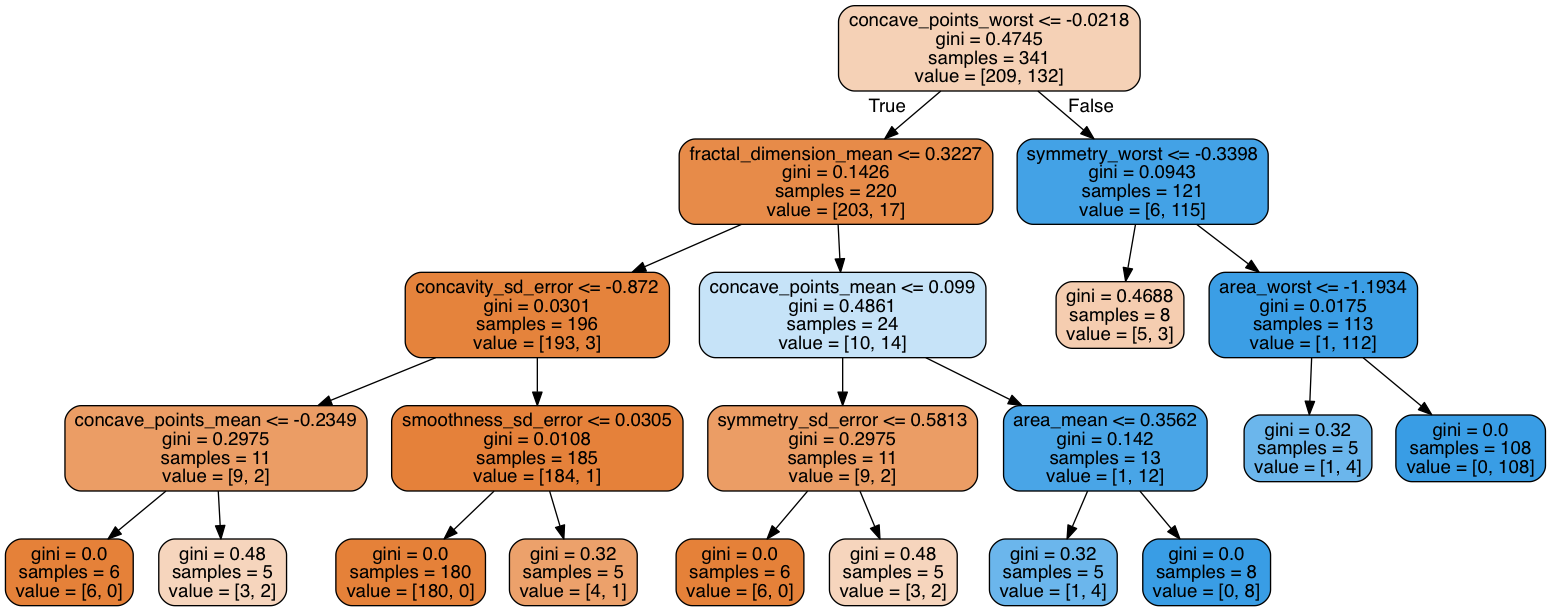

In [5]:
# visualize the classifier
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [6]:
def compute_classification_error(y_true, y_hat):
    accuracy = accuracy_score(y_true, y_hat)
    scorecard = pd.DataFrame({'y_hat': y_hat, 'y_true': y_true})
    false_positives = scorecard[(scorecard['y_true'] == 0) & (scorecard['y_hat'] == 1)]
    false_negatives = scorecard[(scorecard['y_true'] == 1) & (scorecard['y_hat'] == 0)]
    type_1_error = len(false_positives)/len(scorecard)
    type_2_error = len(false_negatives)/len(scorecard)
    print('Accuracy: {:.2f}%'.format(accuracy * 100.0))
    print('Type I error rate: {:.2f}%'.format(type_1_error * 100.0))
    print('Type II error rate: {:.2f}%'.format(type_2_error * 100.0))
    

compute_classification_error(y_true=y_test, y_hat=clf.predict(x_test))

Accuracy: 94.74%
Type I error rate: 1.75%
Type II error rate: 3.51%


In [7]:
# evaluate feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Feature_importance': clf.feature_importances_})
feature_importance.sort_values('Feature_importance', ascending=False).head(5)

,Feature,Feature_importance
23,concave_points_worst,0.801776
27,fractal_dimension_mean,0.092942
21,concave_points_mean,0.049984
26,symmetry_worst,0.038211
25,symmetry_sd_error,0.005879


## Discussion:
1. Which paramter(s) control under-fitting vs over-fitting?
2. How do we know when to stop feature splits in a "greedy" function?
3. Name two ways we can evaluate feature importance?

## Example 2: Regresssion Trees

In [8]:
weather_url = 'https://gist.githubusercontent.com/Ecohen4/3d397b6d9495221757cb5d877031f732/raw/cc57687164505569abad42de9206605e31d5d8d3/weather_data_sample.csv'
weather_data = pd.DataFrame.from_csv(weather_url)
weather_data.index = weather_data.index.tz_localize('UTC')

thermostat_url = 'https://gist.githubusercontent.com/Ecohen4/9fc6829cef1d5e53472cc55e8559d95d/raw/dc9d037a1648891c6bda434015703fa5d09a2518/thermostat_history_sample.csv'
thermostat_data = pd.DataFrame.from_csv(thermostat_url)
thermostat_data.index = thermostat_data.index.tz_localize('UTC')

In [9]:
# prepare data and visually inspect
composite_data = thermostat_data.join(weather_data, how='inner')
composite_data.apply(pd.Categorical).describe()

,comp_cool_1_seconds,comp_cool_2_seconds,control_temperature_f,device_id,humidity,is_thermostat_motion,setpoint_temperature_cool_f,setpoint_temperature_heat_f,thermostat_temperature_f,total_comp_heat_seconds,...,aux_calling_for_heating,is_motion_anywhere,ecobee_control_temperature_f,DHI,DNI,GHI,temperature_f,ground_temp_f,rel_humidity,wind_speed
count,405,405,405.0,405,405,405,405.0,405.0,405.0,405,...,405,405,405.0,405.0,405.0,405.0,405.0,405.00,405.0,405.0
unique,13,1,107.0,1,21,2,16.0,6.0,109.0,1,...,1,2,107.0,146.0,174.0,199.0,238.0,115.00,85.0,109.0
top,0,0,73.0,113,37,False,85.0,60.0,70.4,0,...,False,False,73.0,0.0,0.0,0.0,66.9,75.29,11.0,6.1
freq,325,405,15.0,405,62,354,104.0,364.0,12.0,405,...,405,339,18.0,179.0,208.0,178.0,6.0,12.00,14.0,12.0


In [10]:
# Select predictors (X) and predictand (y), and scale predictors.
dependent_variable = 'thermostat_temperature_f'
independent_variables = ['comp_cool_1_seconds', 'DHI', 'DNI', 'temperature_f', 'ground_temp_f', 'rel_humidity', 'wind_speed']
start, end = '2016-08-02', '2016-08-09'

y = composite_data.loc[start:end, dependent_variable]
X = composite_data.loc[start:end, independent_variables]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [11]:
# timeseries cross-validation
def time_series_out_of_sample_prediction(X, y, classifier, name):
    tscv = TimeSeriesSplit(n_splits=3)
    tscv.split(X)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        classifier.fit(X_train, y_train)    
        pd.DataFrame({'y_hat': classifier.predict(X_test), 'y_true': y_test}).plot(figsize=(12,3))
        plt.title(name)
        plt.ylabel('indoor temperature deg. F')
    

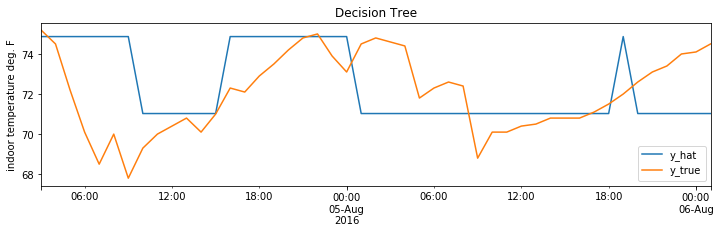

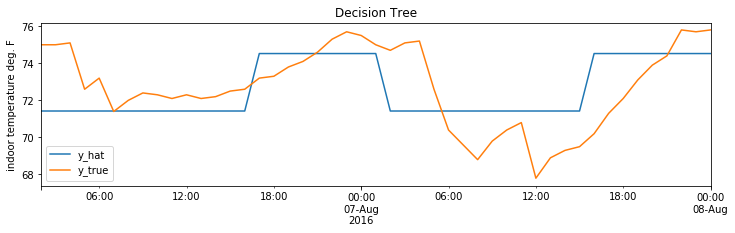

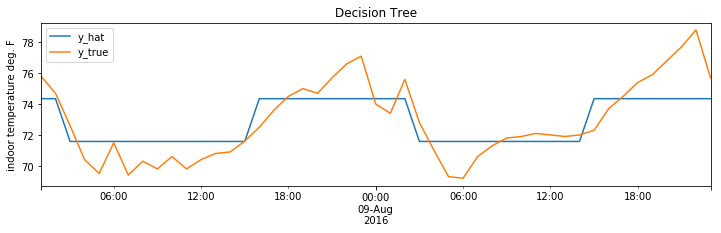

In [12]:
time_series_out_of_sample_prediction(X_scaled, y, tree.DecisionTreeRegressor(max_depth=1), 'Decision Tree')

### Discussion:
1. How do classificaiton and regression trees differ?
2. What are special considerations for applying CART to timeseries data?
3. What are other types of problems for which CART are well-suited?

## Example 3: Ensemble Methods

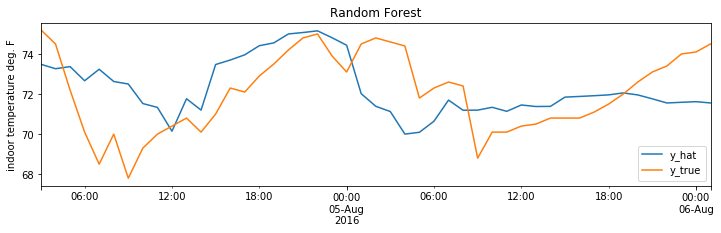

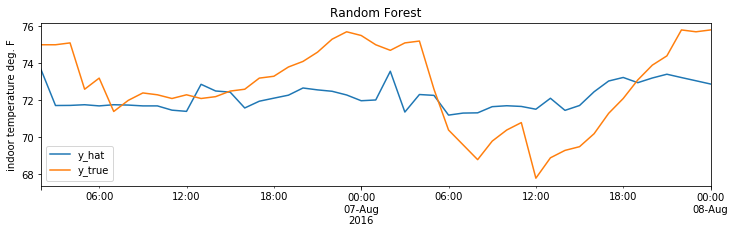

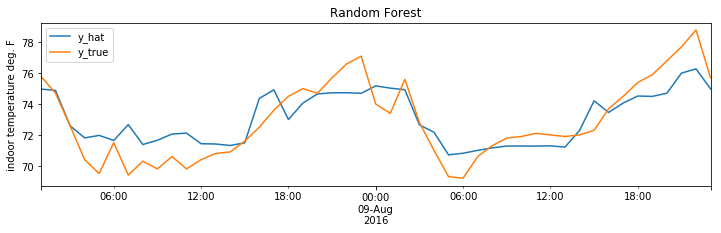

In [13]:
time_series_out_of_sample_prediction(
    X=X_scaled, y=y, name='Random Forest',
    classifier=ensemble.RandomForestRegressor(criterion='mse',  # feature-splitting criterion
                                              n_estimators=200, # number of trees
                                              max_depth=5 # max tree depth
                                             )
)

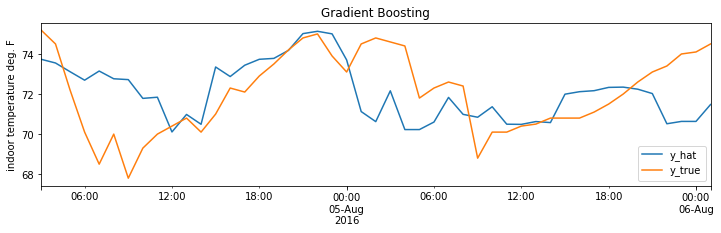

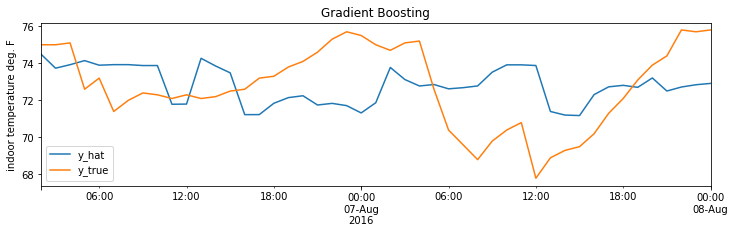

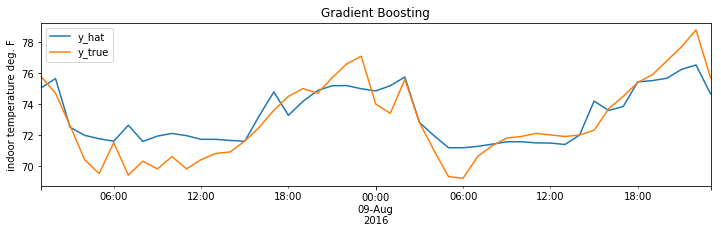

In [14]:
time_series_out_of_sample_prediction(
    X=X_scaled, y=y, name='Gradient Boosting',
    classifier=ensemble.GradientBoostingRegressor(criterion='friedman_mse', # feature splitting criterion
                                                  loss='lad', # overall loss function to be minimized
                                                  n_estimators=200 # number of trees
                                                 )
)

## Discussion
1. What is the advantage of ensemble methods?
2. What is the disadvantage of ensemble methods?
3. With so many hyperparameters, how do we "tune" our model?